In [293]:
import cv2
import numpy as np
from ultralytics import YOLO
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import uuid

In [294]:
# video = cv2.VideoCapture('video_obzor_new_cam_yos_2.avi')
video = cv2.VideoCapture('video_obzor_new_cam_yos_2.avi')

In [295]:
model = YOLO("model_only_car.pt")

In [296]:
video.isOpened()

True

In [288]:
flag, frame = video.read()
fps = video.get(cv2.CAP_PROP_FPS)
height, width, _ = frame.shape
output_video_path = "output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

In [289]:
cv2.imwrite('frame.jpg', frame)

True

In [ ]:
poly1_coords = np.array([[931, 1051], [249, 1040], [749, 287], [964, 284]])
poly2_coords = np.array([[1644, 1061], [978, 1059], [992, 247], [1257, 239]])
poly3_coords = np.array([[916, 1004], [360, 985], [515, 671], [928, 679]])
poly4_coords = np.array([[1297, 471], [964, 475], [968, 365], [1269, 367]])

polygon1 = Polygon(poly1_coords)
polygon2 = Polygon(poly2_coords)
polygon3 = Polygon(poly3_coords)
polygon4 = Polygon(poly4_coords)

(np.float64(-0.5), np.float64(3753.5), np.float64(1045.5), np.float64(-0.5))

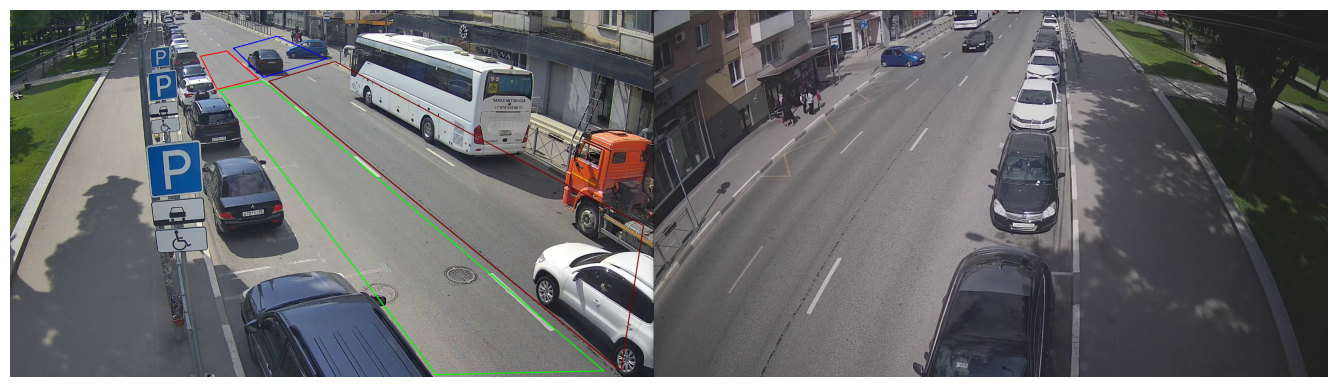

In [ ]:
brg = cv2.polylines(frame, [poly1_coords], isClosed=True, color=(0, 0, 250), thickness=2)
brg = cv2.polylines(frame, [poly2_coords], isClosed=True, color=(250, 0, 0), thickness=2)
brg = cv2.polylines(frame, [poly3_coords], isClosed=True, color=(0, 250, 0), thickness=2)
brg = cv2.polylines(frame, [poly4_coords], isClosed=True, color=(0, 0, 120), thickness=2)
# brg = cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color=(0, 0, 255), thickness=2)
frame_rgb = cv2.cvtColor(brg, cv2.COLOR_BGR2RGB)
cv2.imwrite('frame_with_polygons.jpg', brg)
plt.figure(figsize=(17, 20)) 
plt.imshow(frame_rgb)
plt.axis('off')

для первого видоса

In [3]:
import cv2
import numpy as np
import uuid
from shapely.geometry import Polygon, Point
from ultralytics import YOLO
import matplotlib.pyplot as plt

model = YOLO("model_only_car.pt")
video_path = 'Counting_cars.mp4'
video = cv2.VideoCapture(video_path)

if not video.isOpened():
    print("Ошибка: не удалось открыть видеофайл.")
    exit()

fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_video_path = "output_task2.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

poly1_coords = np.array([[931, 1051], [249, 1040], [749, 287], [964, 284]])
poly2_coords = np.array([[1644, 1061], [978, 1059], [992, 247], [1257, 239]])
poly3_coords = np.array([[916, 1004], [360, 985], [515, 671], [928, 679]])
poly4_coords = np.array([[1297, 471], [964, 475], [968, 365], [1269, 367]])

polygon1 = Polygon(poly1_coords)
polygon2 = Polygon(poly2_coords)
polygon3 = Polygon(poly3_coords)
polygon4 = Polygon(poly4_coords)

confidence = 0.50
car_data = {}
polygon1_counter = 0
frame_count = 0
fps = 5

while True:
    flag, frame = video.read()
    if not flag:
        break
    
    if frame_count % fps == 0:
        display_frame = frame.copy()
        results = model.track(frame, persist=True, conf=confidence)
        info_to_share = None

        if results[0].boxes.id is not None:
            boxes_xyxy = results[0].boxes.xyxy.cpu().numpy()
            track_ids = results[0].boxes.id.int().cpu().tolist()

            # ищу uuid с 3 полигона
            for box, track_id in zip(boxes_xyxy, track_ids):
                x1, y1, x2, y2 = map(int, box)
                center_x = int((x1 + x2) / 2)
                center_y = int((y1 + y2) / 2)
                center_point = Point(center_x, center_y)
                cv2.circle(display_frame, (center_x, center_y), radius=5, color=(255, 0, 0), thickness=-1)

                if polygon3.contains(center_point) and car_data.get(track_id, {}).get('info'):
                    info_to_share = car_data[track_id]['info']
                    break

            for box, track_id in zip(boxes_xyxy, track_ids):
                x1, y1, x2, y2 = map(int, box)
                center_x = int((x1 + x2) / 2)
                center_y = int((y1 + y2) / 2)
                center_point = Point(center_x, center_y)

                if polygon1.contains(center_point) and track_id not in car_data:
                        polygon1_counter += 1
                        car_data[track_id] = {'info': uuid.uuid4().hex[:6]}

                if polygon4.contains(center_point) and info_to_share:
                    car_data.setdefault(track_id, {})
                    if 'shared_info' not in car_data[track_id]:
                        car_data[track_id]['shared_info'] = info_to_share

                current_car_info = car_data.get(track_id)
                
                if polygon4.contains(center_point) and current_car_info and 'shared_info' in current_car_info:
                    label = f'ID:{track_id} {current_car_info["shared_info"]}'
                    cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 165, 255), 3)
                    cv2.putText(display_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 165, 255), 2)

                elif polygon1.contains(center_point) and current_car_info and 'info' in current_car_info:
                    label = f'ID:{track_id} {current_car_info["info"]}'
                    cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 0, 0), 2)
                    cv2.putText(display_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 165, 255), 2)

                elif polygon2.contains(center_point) and current_car_info and 'shared_info' in current_car_info:
                    label = f'ID:{track_id} {current_car_info["shared_info"]}'
                    cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 165, 255), 2)
                    cv2.putText(display_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 165, 255), 2)

        cv2.polylines(display_frame, [poly1_coords], isClosed=True, color=(0, 0, 255), thickness=2)
        cv2.polylines(display_frame, [poly2_coords], isClosed=True, color=(255, 0, 0), thickness=2)
        cv2.polylines(display_frame, [poly3_coords], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.polylines(display_frame, [poly4_coords], isClosed=True, color=(0, 165, 255), thickness=2)
        cv2.putText(display_frame, f'cars: {polygon1_counter}', (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)

        out.write(display_frame)
    frame_count += 1


print(car_data)
video.release()
out.release()


0: 768x1312 14 Cars, 6.7ms
Speed: 3.9ms preprocess, 6.7ms inference, 5.0ms postprocess per image at shape (1, 3, 768, 1312)

0: 768x1312 14 Cars, 6.9ms
Speed: 3.8ms preprocess, 6.9ms inference, 10.8ms postprocess per image at shape (1, 3, 768, 1312)

0: 768x1312 14 Cars, 6.5ms
Speed: 3.7ms preprocess, 6.5ms inference, 11.7ms postprocess per image at shape (1, 3, 768, 1312)

0: 768x1312 14 Cars, 7.0ms
Speed: 3.7ms preprocess, 7.0ms inference, 11.8ms postprocess per image at shape (1, 3, 768, 1312)

0: 768x1312 13 Cars, 6.9ms
Speed: 3.6ms preprocess, 6.9ms inference, 11.1ms postprocess per image at shape (1, 3, 768, 1312)

0: 768x1312 12 Cars, 6.6ms
Speed: 3.6ms preprocess, 6.6ms inference, 10.2ms postprocess per image at shape (1, 3, 768, 1312)

0: 768x1312 12 Cars, 7.0ms
Speed: 3.5ms preprocess, 7.0ms inference, 5.9ms postprocess per image at shape (1, 3, 768, 1312)

0: 768x1312 11 Cars, 6.7ms
Speed: 3.8ms preprocess, 6.7ms inference, 10.3ms postprocess per image at shape (1, 3, 768, 

In [4]:
car_data

{1: {'info': 'b51d0c'},
 5: {'info': '630bb3'},
 6: {'info': '2acd01'},
 8: {'info': '7f9977'},
 14: {'info': '4b5f65'},
 13: {'received_info': 'b51d0c'},
 16: {'received_info': 'b51d0c'},
 20: {'received_info': 'b51d0c'},
 21: {'info': '8cea33'},
 27: {'info': '619928'},
 11: {'received_info': '630bb3'},
 31: {'info': '3a49b0'},
 29: {'received_info': '630bb3'},
 33: {'info': 'd25faa'},
 35: {'info': 'ef4c2e'},
 38: {'received_info': '7f9977'},
 41: {'info': 'cc0f45'},
 43: {'info': '6ec740'},
 58: {'info': 'a8b695'},
 60: {'received_info': '4b5f65'},
 53: {'received_info': '4b5f65'},
 61: {'info': '8c7cc6'},
 62: {'info': 'f9792a'},
 65: {'info': '388a20'},
 71: {'info': '21b61c'},
 73: {'info': 'ec85e2'},
 76: {'info': 'bcf7db'},
 46: {'received_info': 'ec85e2'},
 82: {'info': '064bac'},
 89: {'info': '126f27'},
 96: {'info': 'fbb033'},
 98: {'info': '2ee220'},
 103: {'received_info': '126f27'},
 105: {'received_info': '126f27'},
 108: {'info': '1efa53'},
 112: {'info': 'c8fb6e'},
 

In [303]:
poly3_coords_left = np.array([[617, 119], [707, 198], [590, 228], [542, 134]])
poly4_coords_left = np.array([[760, 77], [902, 141], [722, 194], [636, 111]])
poly1_coords_left = np.array([[722, 205], [1691, 1028], [1214, 1039], [598, 231]])
poly2_coords_left = np.array([[1729, 1020], [737, 205], [925, 149], [1804, 615], [1740, 1024], [1721, 1016]])

poly4_coords_right =  np.array([[2757, 161], [2564, 128], [2689, 50], [2835, 73]])
poly3_coords_right =  np.array([[2882, 175], [2767, 161], [2838, 73], [2920, 90]])
poly2_coords_right =  np.array([[2184, 955], [1848, 816], [2509, 148], [2726, 189]])
poly1_coords_right =  np.array([[2882, 219], [2740, 185], [2224, 959], [2580, 1026]])
polygon1_left = Polygon(poly1_coords_left)
polygon2_left = Polygon(poly2_coords_left)
polygon3_left = Polygon(poly3_coords_left)
polygon4_left = Polygon(poly4_coords_left)

polygon1_right = Polygon(poly1_coords_right)
polygon2_right = Polygon(poly2_coords_right)
polygon3_right = Polygon(poly3_coords_right)
polygon4_right = Polygon(poly4_coords_right)

(np.float64(-0.5), np.float64(3753.5), np.float64(1045.5), np.float64(-0.5))

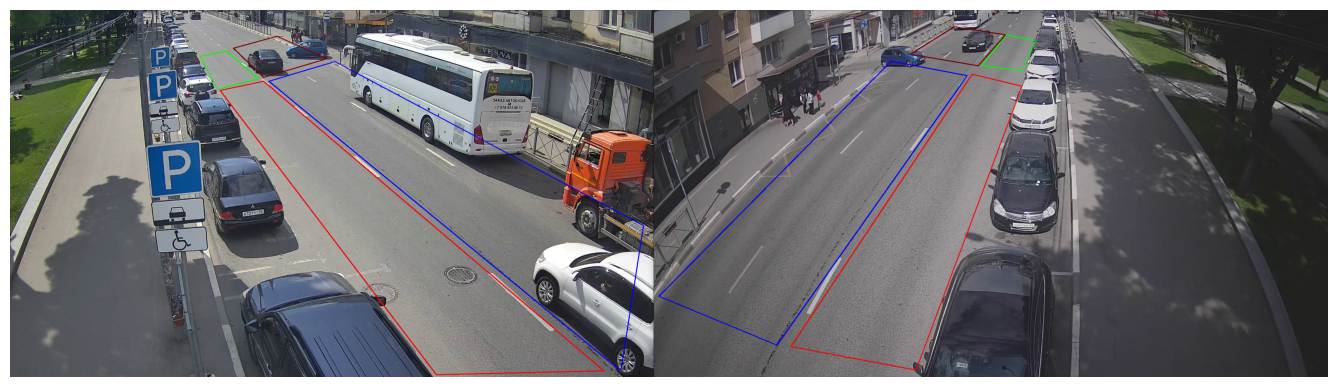

In [304]:
video = cv2.VideoCapture('video_obzor_new_cam_yos_2.avi')
flag, frame = video.read()
fps = video.get(cv2.CAP_PROP_FPS)
height, width, _ = frame.shape
output_video_path = "output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

brg = cv2.polylines(frame, [poly1_coords_left], isClosed=True, color=(0, 0, 250), thickness=2)
brg = cv2.polylines(frame, [poly2_coords_left], isClosed=True, color=(250, 0, 0), thickness=2)
brg = cv2.polylines(frame, [poly3_coords_left], isClosed=True, color=(0, 250, 0), thickness=2)
brg = cv2.polylines(frame, [poly4_coords_left], isClosed=True, color=(0, 0, 120), thickness=2)
brg = cv2.polylines(frame, [poly1_coords_right], isClosed=True, color=(0, 0, 250), thickness=2)
brg = cv2.polylines(frame, [poly2_coords_right], isClosed=True, color=(250, 0, 0), thickness=2)
brg = cv2.polylines(frame, [poly3_coords_right], isClosed=True, color=(0, 250, 0), thickness=2)
brg = cv2.polylines(frame, [poly4_coords_right], isClosed=True, color=(0, 0, 120), thickness=2)
# brg = cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color=(0, 0, 255), thickness=2)
frame_rgb = cv2.cvtColor(brg, cv2.COLOR_BGR2RGB)
cv2.imwrite('frame_with_polygons.jpg', brg)
plt.figure(figsize=(17, 20)) 
plt.imshow(frame_rgb)
plt.axis('off')

таск с двойной камерой, где uuid переходит с одной камеры на другую

In [ ]:
import cv2
import numpy as np
import uuid
from shapely.geometry import Polygon, Point
from ultralytics import YOLO

model = YOLO("model_only_car.pt")
video = cv2.VideoCapture('video_obzor_new_cam_yos_2.avi')

if not video.isOpened():
    print("Ошибка: не удалось открыть видеофайл.")
    exit()

fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

left_width = width // 2

output_video_path = "output_task2_main1.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

roi_left = np.array([[1790, 39], [1777, 1016], [477, 1009], [461, 50]])
roi_right = np.array([[1861, 39], [1872, 1003], [2852, 996], [2893, 43]])

mask_left = np.zeros((height, width), dtype=np.uint8)
mask_right = np.zeros((height, width), dtype=np.uint8)
cv2.fillPoly(mask_left, [roi_left], 255)
cv2.fillPoly(mask_right, [roi_right], 255)

poly1_left_coords = np.array([[1543, 901], [1831, 745], [705, 80], [610, 94], [1539, 894]])
poly2_left_coords = np.array([[1515, 898], [1203, 1016], [515, 117], [593, 94]])
poly3_left_coords = np.array([[617, 119], [707, 198], [590, 228], [542, 134]])
poly4_left_coords = np.array([[760, 77], [902, 141], [722, 194], [636, 111]])

polygon1_left = Polygon(poly2_left_coords)
polygon2_left = Polygon(poly1_left_coords)
polygon3_left = Polygon(poly3_left_coords)
polygon4_left = Polygon(poly4_left_coords)

poly1_right_coords = np.array([[2920, 66], [2835, 53], [2211, 962], [2577, 1030]])
poly2_right_coords = np.array([[2675, 33], [2848, 50], [2194, 942], [1838, 792]])
poly3_right_coords = np.array([[2882, 175], [2767, 161], [2838, 73], [2920, 90]])
poly4_right_coords = np.array([[2757, 161], [2564, 128], [2689, 50], [2835, 73]])

polygon1_right = Polygon(poly1_right_coords)
polygon2_right = Polygon(poly2_right_coords)
polygon3_right = Polygon(poly3_right_coords)
polygon4_right = Polygon(poly4_right_coords)

COLOR_POLY1 = (0, 0, 255)  
COLOR_POLY2 = (255, 0, 0)  
COLOR_POLY3 = (0, 255, 0)  
COLOR_POLY4 = (0, 165, 255)

confidence = 0.50
car_data = {} 
polygon_counter = 0
frame_count = 0

uuid_poly3 = None   
uuid_poly4 = None   

def is_in_roi(x, y, mask):
    """Проверяет, находится ли точка в ROI"""
    if 0 <= x < width and 0 <= y < height:
        return mask[y, x] > 0
    return False

while True:
    flag, frame = video.read()
    if not flag:
        break
    
    display_frame = frame.copy()
    
    results = model.track(frame, persist=True, conf=confidence)
    
    uuid_poly3 = None
    uuid_poly4 = None
    
    if results[0].boxes is not None and results[0].boxes.id is not None:
        boxes_xyxy = results[0].boxes.xyxy.cpu().numpy()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        confidences = results[0].boxes.conf.cpu().numpy()
        
        # левая чать
        for box, track_id, conf in zip(boxes_xyxy, track_ids, confidences):
            x1, y1, x2, y2 = map(int, box)
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)
            center_point = Point(center_x, center_y)
            
            if is_in_roi(center_x, center_y, mask_left):
                in_polygon1 = polygon1_left.contains(center_point)
                in_polygon2 = polygon2_left.contains(center_point)
                is_in_polygon3 = polygon3_left.contains(center_point)
                is_in_polygon4 = polygon4_left.contains(center_point)
                
                if in_polygon1 and track_id not in car_data:
                    polygon_counter += 1
                    car_data[track_id] = {
                        'uuid': uuid.uuid4().hex[:6],
                        'color': COLOR_POLY1
                    }
                
                if in_polygon2 and track_id not in car_data:
                    polygon_counter += 1
                    car_data[track_id] = {
                        'uuid': uuid.uuid4().hex[:6],
                        'color': COLOR_POLY2
                    }
            
                if is_in_polygon3 and track_id in car_data:
                    uuid_poly3 = car_data[track_id]['uuid']
                
                if is_in_polygon4 and track_id in car_data:
                    uuid_poly4 = car_data[track_id]['uuid']
                    
        # правая часть
        for box, track_id, conf in zip(boxes_xyxy, track_ids, confidences):
            x1, y1, x2, y2 = map(int, box)
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)
            center_point = Point(center_x, center_y)
            
            if is_in_roi(center_x, center_y, mask_right):
                is_in_polygon3 = polygon3_right.contains(center_point)
                is_in_polygon4 = polygon4_right.contains(center_point)
                
                if is_in_polygon3 and track_id not in car_data and uuid_poly3:
                    car_data[track_id] = {
                        'uuid': uuid_poly3,
                        'color': COLOR_POLY3
                    }
                
                if is_in_polygon4 and track_id not in car_data and uuid_poly4:
                    car_data[track_id] = {
                        'uuid': uuid_poly4,
                        'color': COLOR_POLY4
                    }
        
        # рисую боксы
        for box, track_id, conf in zip(boxes_xyxy, track_ids, confidences):
            x1, y1, x2, y2 = map(int, box)
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)
            center_point = Point(center_x, center_y)
            
            in_left_roi = is_in_roi(center_x, center_y, mask_left)
            in_right_roi = is_in_roi(center_x, center_y, mask_right)
            
            if not in_left_roi and not in_right_roi:
                continue
            
            in_any_polygon = False
            
            if in_left_roi:
                if (polygon1_left.contains(center_point) or polygon2_left.contains(center_point) or 
                    polygon3_left.contains(center_point) or polygon4_left.contains(center_point)):
                    in_any_polygon = True
            
            if in_right_roi:
                if (polygon1_right.contains(center_point) or polygon2_right.contains(center_point) or 
                    polygon3_right.contains(center_point) or polygon4_right.contains(center_point)):
                    in_any_polygon = True
            
            if in_any_polygon and track_id in car_data:
                box_color = car_data[track_id]['color']
                
                cv2.rectangle(display_frame, (x1, y1), (x2, y2), box_color, 2)

                label = f'ID:{track_id} [{conf:.2f}] UUID:{car_data[track_id]["uuid"]}'
                
                cv2.putText(display_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)
    
    cv2.polylines(display_frame, [poly1_left_coords], isClosed=True, color=COLOR_POLY2, thickness=2)
    cv2.polylines(display_frame, [poly2_left_coords], isClosed=True, color=COLOR_POLY1, thickness=2)
    cv2.polylines(display_frame, [poly3_left_coords], isClosed=True, color=COLOR_POLY3, thickness=2)
    cv2.polylines(display_frame, [poly4_left_coords], isClosed=True, color=COLOR_POLY4, thickness=2)
    
    cv2.polylines(display_frame, [poly1_right_coords], isClosed=True, color=COLOR_POLY1, thickness=2)
    cv2.polylines(display_frame, [poly2_right_coords], isClosed=True, color=COLOR_POLY2, thickness=2)
    cv2.polylines(display_frame, [poly3_right_coords], isClosed=True, color=COLOR_POLY3, thickness=2)
    cv2.polylines(display_frame, [poly4_right_coords], isClosed=True, color=COLOR_POLY4, thickness=2)
    
    cv2.putText(display_frame, f'cars: {polygon_counter}', (100, 100), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, ), 3)
    
    out.write(display_frame)
    frame_count += 1

video.release()
out.release()


0: 384x1312 18 Cars, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 1312)

0: 384x1312 17 Cars, 4.5ms
Speed: 2.6ms preprocess, 4.5ms inference, 11.1ms postprocess per image at shape (1, 3, 384, 1312)

0: 384x1312 16 Cars, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 1312)

0: 384x1312 17 Cars, 5.3ms
Speed: 2.2ms preprocess, 5.3ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 1312)

0: 384x1312 16 Cars, 4.7ms
Speed: 2.4ms preprocess, 4.7ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 1312)

0: 384x1312 16 Cars, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 1312)

0: 384x1312 17 Cars, 4.8ms
Speed: 2.3ms preprocess, 4.8ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 1312)

0: 384x1312 17 Cars, 4.9ms
Speed: 2.3ms preprocess, 4.9ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 1

In [337]:
car_data

{9: {'uuid': '833356', 'color': (255, 0, 0)},
 12: {'uuid': '833356', 'color': (0, 165, 255)},
 3: {'uuid': 'e41cc8', 'color': (255, 0, 0)},
 21: {'uuid': 'ddbee1', 'color': (255, 0, 0)},
 19: {'uuid': 'e41cc8', 'color': (0, 165, 255)},
 24: {'uuid': 'f26a52', 'color': (255, 0, 0)},
 22: {'uuid': 'ddbee1', 'color': (0, 255, 0)},
 26: {'uuid': 'f26a52', 'color': (0, 165, 255)},
 27: {'uuid': 'bd8681', 'color': (0, 0, 255)},
 30: {'uuid': '5709a9', 'color': (255, 0, 0)},
 28: {'uuid': 'bd8681', 'color': (0, 255, 0)},
 32: {'uuid': '5709a9', 'color': (0, 165, 255)},
 16: {'uuid': 'ccb26d', 'color': (255, 0, 0)},
 34: {'uuid': '612076', 'color': (255, 0, 0)},
 35: {'uuid': '612076', 'color': (0, 165, 255)}}